# Libraries and modules imports

In [1]:
%load_ext autoreload
%autoreload 2

import torch 
print('Pytorch version :', torch.__version__)

from Class_PINN import PINN
from Class_CollocationPoints import CollocationPoints
from Class_ObservationPoints import ObservationPoints
from Backwater_model import J, compute_ref_solution
import display

Pytorch version : 2.6.0+cu124


# Cuda setup

In [2]:
# Device choice
use_GPU = True #Choose whether you want to use your GPU or not

if (torch.cuda.is_available() and use_GPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Running on {device} !')

#Additional info when using cuda
if (device.type == 'cuda'):
    print('GPU :', torch.cuda.get_device_name(0))
    print('Total memory :', 
          round(torch.cuda.get_device_properties(0).total_memory/1024**3, 1), 'GB')

#Set default usage to CPU or GPU
torch.set_default_device(device)

Running on cuda !
GPU : NVIDIA RTX A500 Laptop GPU
Total memory : 3.8 GB


# $k_{true}$ definition

In [3]:
k_true = torch.tensor([45, 38, 28, 22, 30, 45, 60, 75]) #You can modify the value of k_true here !

# Collocation points definition

In [4]:
col = CollocationPoints(device, 
                        random = False, #Choose between grid collocation points (=True) and random collocation points (=False)
                        N_col = 100, #Choose number of collocation points
                        variable_boundaries = (0, 1000), #Choose the boundaries of the domain
                        test_size = 0, #Choose the testing set / training set ratio
                        seed = 0) #Set the seed to any integer number for reproductible randomness

# PINN definition

In [5]:
model = PINN(device, col = col,
             layers = [1, 40, 1], #Choose the neural network architecture
             k_0 = 40*torch.ones_like(k_true), #Choose the initialization value for k
             k_ref = 40, #Choose the reference value for scaling k
             k_interpolation = 'P1', #Choose the interpolation method for the k function (P1 or P0)
             seed = 0) #Set the seed to any integer number for reproductible randomness

# Reference solution and Observations generation

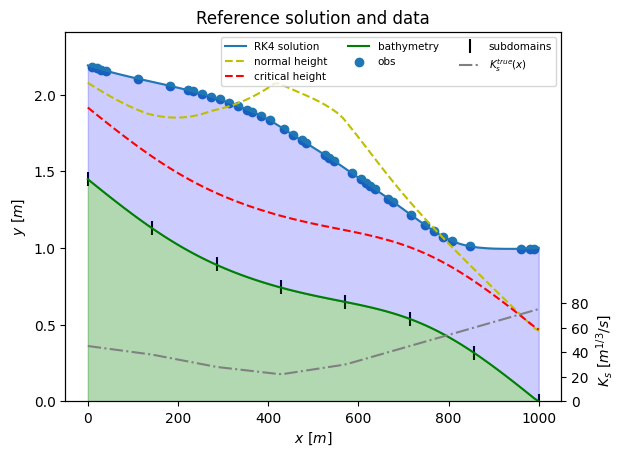

In [6]:
ref_solution = compute_ref_solution(model, col, k = k_true, dx = 10) 

obs = ObservationPoints(ref_solution, 
                        N_obs = 40, #Choose the number of observations in the domain
                        noise_std = 0, #Choose the standard deviation of the white noise added to the observations
                        seed = None) #Set the seed to any integer number for reproductible randomness

display.display_data(model, col, ref_solution, obs) 

# Model training 

##################################################
Processing iteration 50 (iter + eval = 64)
-------------------------
J           = 3.95e-03 (residual : 0.00e+00, BC : 3.38e-03, obs : 5.64e-04)
||grad(J)|| = 3.21e-01
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.], device='cuda:0')
time           = 2.83 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory        : 0.0 GB
##################################################
Processing iteration 100 (iter + eval = 133)
-------------------------
J           = 1.08e-04 (residual : 0.00e+00, BC : 1.07e-04, obs : 3.24e-07)
||grad(J)|| = 1.66e-04
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.], device='cuda:0')
time           = 4.34 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory 

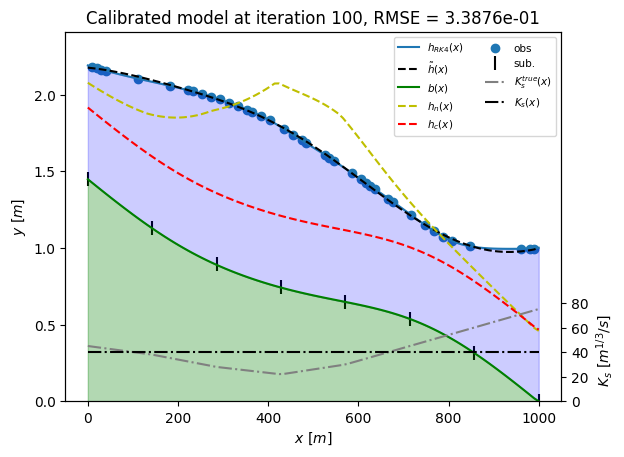

##################################################
Processing iteration 150 (iter + eval = 341)
-------------------------
J           = 1.27e-04 (residual : 8.02e-06, BC : 1.10e-04, obs : 9.38e-06)
||grad(J)|| = 7.22e-02
parameter      = tensor([52.8907, 35.4037, 26.7024, 23.2006, 27.6595, 46.6863, 58.9025, 52.2809],
       device='cuda:0')
time           = 7.91 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory        : 0.0 GB
##################################################
Processing iteration 200 (iter + eval = 512)
-------------------------
J           = 1.12e-04 (residual : 3.87e-06, BC : 1.07e-04, obs : 1.15e-06)
||grad(J)|| = 1.40e-02
parameter      = tensor([58.6227, 33.9776, 27.5328, 22.8642, 27.8286, 47.7984, 55.5799, 78.8194],
       device='cuda:0')
time           = 10.47 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.

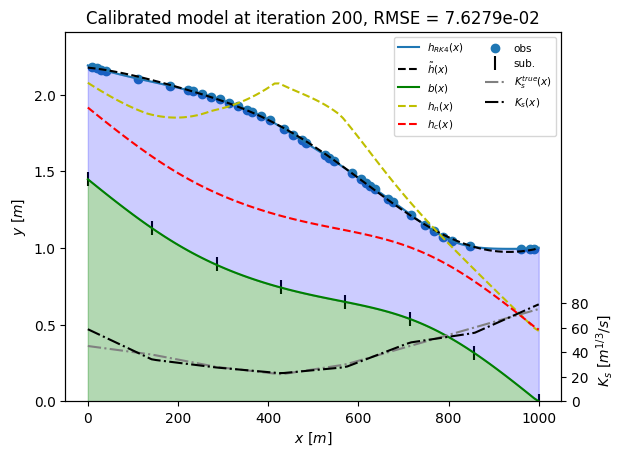

##################################################
Processing iteration 250 (iter + eval = 682)
-------------------------
J           = 1.16e-04 (residual : 3.69e-06, BC : 1.07e-04, obs : 4.92e-06)
||grad(J)|| = 4.60e-02
parameter      = tensor([55.9511, 34.3643, 27.4046, 22.9398, 27.7173, 47.6914, 55.3656, 79.8005],
       device='cuda:0')
time           = 13.23 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3.8 GB
Max Allocated memory : 0.0 GB
Allocated memory     : 0.0 GB
Reserved memory        : 0.0 GB
##################################################
Processing iteration 300 (iter + eval = 867)
-------------------------
J           = 1.19e-04 (residual : 3.67e-06, BC : 1.08e-04, obs : 7.66e-06)
||grad(J)|| = 6.07e-02
parameter      = tensor([56.1110, 34.1943, 27.5209, 22.9195, 27.7113, 47.6871, 55.0642, 81.0591],
       device='cuda:0')
time           = 15.82 s
-------------------------
GPU : NVIDIA RTX A500 Laptop GPU
Total memory         : 3

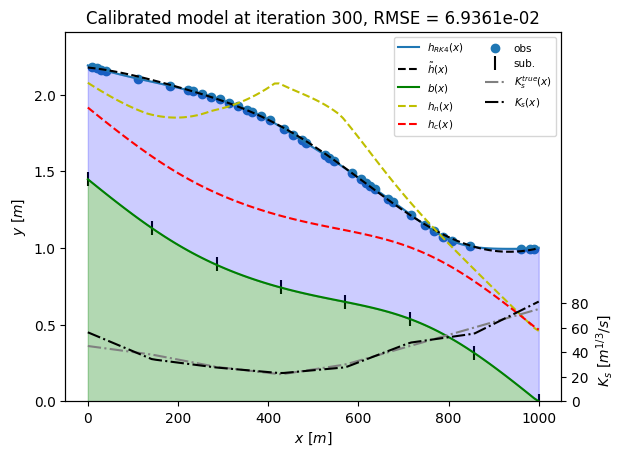

In [7]:
model.train_model(J, col, obs, ref_solution, 
                  normalize_J = True, #Choose whether you want to normalize J by J_0 or not
                  pre_train_iter = 100, #Choose the number of iterations for pre-training
                  alter_steps = 4, #Choose the number of alternating minimization steps
                  alter_freq = (40, 10), #Choose the number of iterations on theta (first value) and on k (second value) for each step
                  display_freq = (50, 100)) #Choose the display frequency for the training informations (first value) and the results plot (second value)

# Display training and results

##################################################
Final parameter RMSE : 6.94e-02
Final variable RMSE : 1.02e-02
##################################################


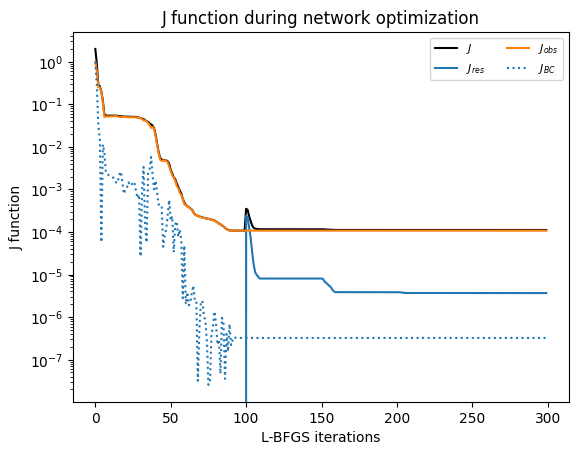

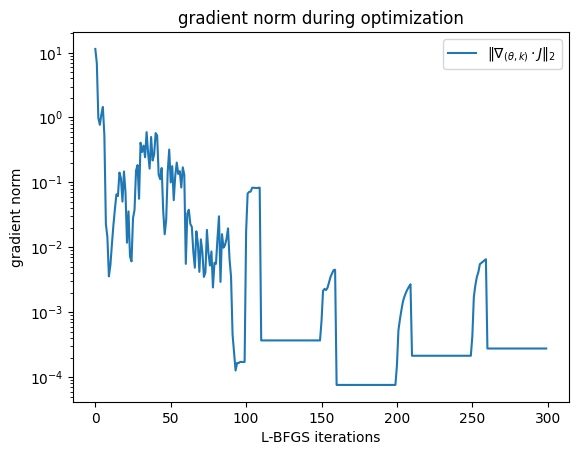

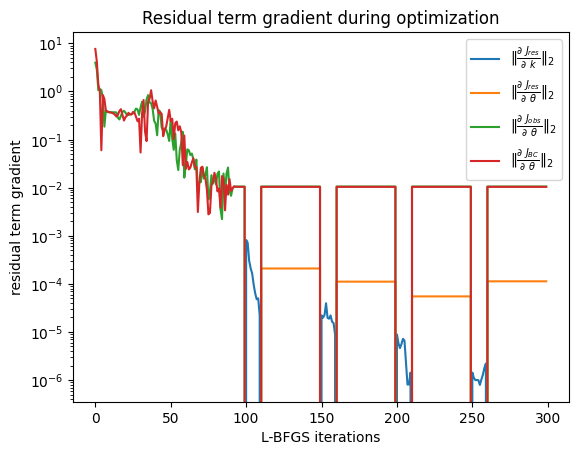

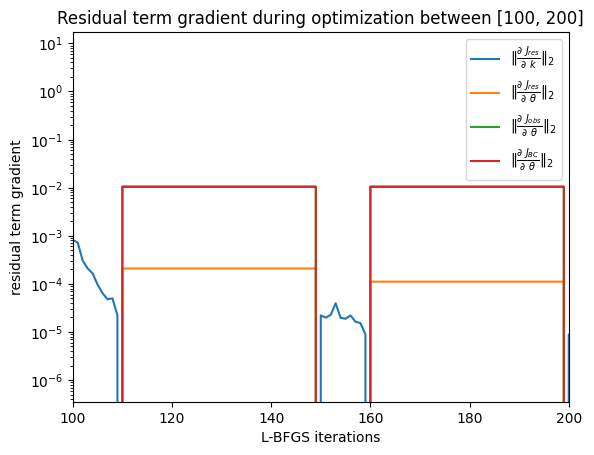

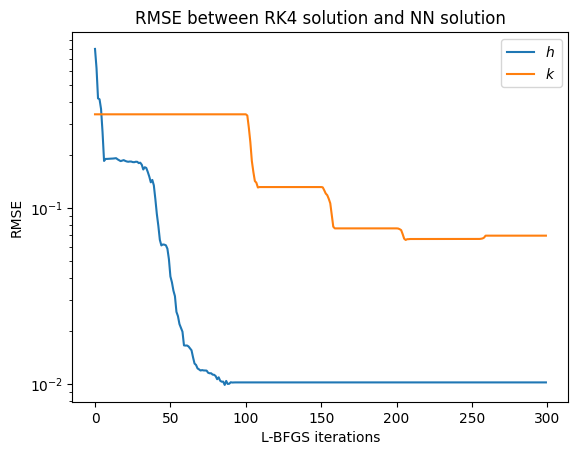

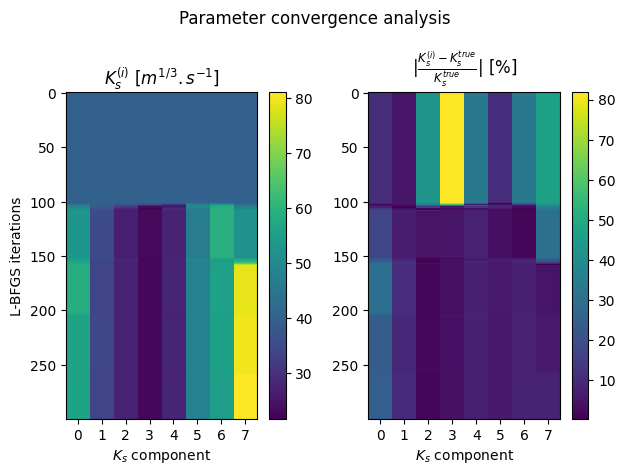

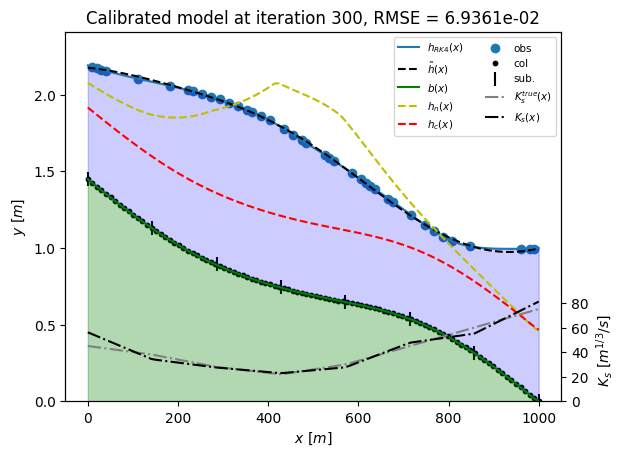

In [8]:
display.display_training(model, col, ref_solution)

display.display_results(model, col, ref_solution, obs, plot_col = True)